# Franken goam analysis

The data for this example can be found [here](https://cloudstor.aarnet.edu.au/plus/apps/files/?dir=/MRI-Linac%20Experimental%20Data/FrankenGoam%5EMr&fileid=6991872825).

I'm first going to set up the variables to read in this data

In [4]:
dataloc = Path(r'/home/brendan/Downloads/FrankenGoam^Mr/20221107 MR Linac^Test')
from pathlib import Path
from mri_distortion_toolkit.MarkerAnalysis import MarkerVolume, MatchedMarkerVolumes
from mri_distortion_toolkit.utilities import enumerate_subfolders


scans = {'0': '01 localiser_gre',
         '1': '02 localiser_gre',
         '2': '03 localiser_gre',
         '3': '04 gre_trans_AP_330',
         '4': '05 gre_trans_PA_330',
         '5': '06 gre_sag_AP_330',
         '6': '07 gre_sag_PA_330',
         '7': '08 gre_cor_RL_330',
         '8': '09 gre_cor_LR_330',
         '9': '10 t1_tse_256_sag',
         '10': '11 t1_tse_256_sag_PA',
         '11': '12 t1_tse_256_tra_PA',
         '12': '13 t1_tse_256_sag_HF',
         '13': '14 t1_tse_256_sag_FH',  # for this one had to add gaussian_image_filter_sd=0.8
         '14': '15 t1_tse_256_cor_RL',
         '15': '16 t1_tse_256_cor_LR',
         '16': '17 localiser_gre',
         '17': '18 t1_tse_256_sag_HF_rot',
         '18': '19 t1_tse_256_sag_FH_rot',
         '19': '20 trufi_sag_128_torsocoil',
         '20': '21 trufi_sag_128_torsocoil',
         '21': '22 trufi_sag_128_torsocoil'}

## Marker extraction

Our first step is to extract the markers from each phantom.
Note that you can skip this step if you have already extracted and saved the marker positions as the next steps will read in these data files.

In [5]:
# process TSE images
scans_to_segment = ['9', '11', '12', '13', '14']
gaussian_sd = [1,1,1,0.8,1,1]
for scan, sd in zip(scans_to_segment, gaussian_sd):
    volume = MarkerVolume(dataloc / scans[scan] / 'Original', n_markers_expected=618, iterative_segmentation=True,
                          gaussian_image_filter_sd=sd)
    print(f'for {scans[scan]}, {volume.MarkerCentroids.shape[0]} markers found')
    volume.export_to_slicer()
    volume.save_dicom_data()

Using thresold of  331.1
total segmentation time:  63.2 s
for 10 t1_tse_256_sag, 618 markers found
Using thresold of  315.5
total segmentation time:  64.2 s
for 12 t1_tse_256_tra_PA, 618 markers found
Using thresold of  254.4
total segmentation time:  48.5 s
for 13 t1_tse_256_sag_HF, 618 markers found
Using thresold of  254.4
total segmentation time:  45.6 s
for 14 t1_tse_256_sag_FH, 618 markers found
Using thresold of  241.9
total segmentation time:  50.2 s
for 15 t1_tse_256_cor_RL, 618 markers found


## Marker Matching

The next step is to match the markers from each of the distorted datasets to the ground truth data. Note that we have previously segmented the ground truth data, and simply import the pre-segmented data here.

In [3]:
from mri_distortion_toolkit.MarkerAnalysis import MatchedMarkerVolumes

ct_loc = Path(r'/home/brendan/Downloads/FrankenGoam^Mr/CT/slicer_centroids.mrk.json')
if not Path('_data').is_dir():
    Path('_data').mkdir

gt_vol = MarkerVolume(ct_loc)
gt_vol.rotate_markers(yaxis_angle=180)  # rotate the ground truth so it matched acquisition geometry

tra_forward_vol = MarkerVolume(dataloc / scans['0'] / 'Original' / 'slicer_centroids.mrk.json')
tra_back_vol = MarkerVolume(dataloc / scans['2'] / 'Original' / 'slicer_centroids.mrk.json')
tra_match = MatchedMarkerVolumes(gt_vol, tra_forward_vol, reverse_gradient_data=tra_back_vol, n_refernce_markers=9)
tra_match.MatchedCentroids.to_csv('_data/tra_markers.csv')

sag_forward_vol = MarkerVolume(dataloc / scans['3'] / 'Original' / 'slicer_centroids.mrk.json')
sag_back_vol = MarkerVolume(dataloc / scans['4'] / 'Original' / 'slicer_centroids.mrk.json')
sag_match = MatchedMarkerVolumes(gt_vol, sag_forward_vol, reverse_gradient_data=sag_back_vol, n_refernce_markers=9)
sag_match.MatchedCentroids.to_csv('_data/sag_markers.csv')

cor_forward_vol = MarkerVolume(dataloc / scans['5'] / 'Original' / 'slicer_centroids.mrk.json')
cor_back_vol = MarkerVolume(dataloc / scans['6'] / 'Original' / 'slicer_centroids.mrk.json')
cor_match = MatchedMarkerVolumes(gt_vol, cor_forward_vol, reverse_gradient_data=cor_back_vol, n_refernce_markers=9)
cor_match.MatchedCentroids.to_csv('_data/cor_markers.csv')

[MarkerAnalysis.py: line 128  WARNING] MR data file dicom_data.json not found at /home/brendan/Downloads/FrankenGoam^Mr/CT. Continuing


aligning ground truth centroids by 
x     0.933333
y   -54.882222
z    -3.753333
dtype: float64
rotating ground truth centroids by 
[[ 0.99956145 -0.02737767 -0.0112856 ]
 [ 0.02757548  0.9994619   0.01776225]
 [ 0.01079323 -0.01806567  0.99977854]]
aligning ground truth centroids by 
x     0.812222
y   -54.786667
z    -3.748889
dtype: float64
rotating ground truth centroids by 
[[ 0.99944264 -0.03303426 -0.00481124]
 [ 0.03311539  0.99929138  0.01789175]
 [ 0.00421679 -0.0180411   0.99982835]]
aligning ground truth centroids by 
x     0.870000
y   -54.838889
z    -3.707778
dtype: float64
rotating ground truth centroids by 
[[ 0.99965388 -0.02590762 -0.00457264]
 [ 0.02598162  0.99951881  0.01694392]
 [ 0.00413146 -0.01705686  0.99984599]]


In [ ]:
tra_forward_vol.plot

## Field calculation

Next step is to calculate the encoding fields from the distorted marker positions. Note that we obtain three field estimates; one from each forward/reverse marker set. Each field calculation includes an estimate of the gradient fields and the B0 field.

In [4]:
from mri_distortion_toolkit.FieldCalculation import ConvertMatchedMarkersToBz
import pandas as pd

data_csv_loc = Path('_data').resolve()
# load the matched volume calculated in the previous step.
matched_volume = pd.read_csv(data_csv_loc / 'tra_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['0'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'tra_Bfields.csv')

matched_volume = pd.read_csv(data_csv_loc / 'sag_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['3'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'sag_Bfields.csv')

matched_volume = pd.read_csv(data_csv_loc / 'cor_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['5'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'cor_Bfields.csv')

## Harmonic calculation and averaging

We are now able to calculate the harmonics from each field data set.
Note that for each forward/reverse data set, we obtain:

- a good estimate of B0 (from the marker offsets in the frequency encode direction)
- A good estimate of the gradient in the **phase** and **frequency** direction.

The fields in the **slice encode** direction are not reliable, as in this direction we are not able to seperate out B0 and gradient effects. Therefore, we will simply discard these fields. The below table sums up which fields are involved in each direction:

| Scan orientation | Slice direction | Phase direction | Frequency direction |
| ---------------- | --------------- | --------------- | ------------------- |
| Transverse       | z               | **y**           | **x**               |
| Coronal          | y               | **x**           | **z**               |
| Sagital          | x               | **z**           | **y**               |

For each gradient, we obtain two estimates that we trust. We will simply take the average of these two estimates, and use this as our 'best guess'.

### Calculate all harmonics and save as csv:

In [5]:
from mri_distortion_toolkit import calculate_harmonics
import numpy as np
from mri_distortion_toolkit.utilities import get_dicom_data

# Transverse data
# ===================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'tra_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['0'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=[5, 5, 5, 8],
                                                                                scale=normalisation_factor)
# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_tra.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_tra.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_tra.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_tra.csv')
    
# Sagital Data
# ======================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'sag_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['3'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=[5, 5, 5, 8],
                                                                                scale=normalisation_factor)
# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_sag.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_sag.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_sag.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_sag.csv')
    
# Coronal data
# ======================================================================================================================

FieldData = pd.read_csv(data_csv_loc / 'cor_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['5'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=[5, 5, 5, 8],
                                                                                scale=normalisation_factor)

# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_cor.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_cor.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_cor.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_cor.csv')


Initial pk-pk:        9.889e+02 μT
Reconstructed pk-pk:  9.884e+02 μT
Residual pk-pk:       3.581e+00 μT ( 0.4%)
Initial pk-pk:        9.885e+02 μT
Reconstructed pk-pk:  9.889e+02 μT
Residual pk-pk:       2.371e+00 μT ( 0.2%)
Initial pk-pk:        3.319e+02 μT
Reconstructed pk-pk:  3.338e+02 μT
Residual pk-pk:       5.242e+00 μT ( 1.6%)


[Harmonics.py: line 176  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        2.444e+01 μT
Reconstructed pk-pk:  2.426e+01 μT
Residual pk-pk:       3.998e+00 μT ( 16.4%)
Initial pk-pk:        2.799e+02 μT
Reconstructed pk-pk:  2.790e+02 μT
Residual pk-pk:       4.997e+00 μT ( 1.8%)
Initial pk-pk:        9.357e+02 μT
Reconstructed pk-pk:  9.364e+02 μT
Residual pk-pk:       3.189e+00 μT ( 0.3%)
Initial pk-pk:        1.114e+03 μT
Reconstructed pk-pk:  1.113e+03 μT
Residual pk-pk:       1.339e+01 μT ( 1.2%)


[Harmonics.py: line 176  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        2.484e+01 μT
Reconstructed pk-pk:  2.561e+01 μT
Residual pk-pk:       3.641e+00 μT ( 14.7%)
Initial pk-pk:        9.368e+02 μT
Reconstructed pk-pk:  9.364e+02 μT
Residual pk-pk:       2.981e+00 μT ( 0.3%)
Initial pk-pk:        2.786e+02 μT
Reconstructed pk-pk:  2.776e+02 μT
Residual pk-pk:       4.812e+00 μT ( 1.7%)
Initial pk-pk:        1.112e+03 μT
Reconstructed pk-pk:  1.112e+03 μT
Residual pk-pk:       1.314e+01 μT ( 1.2%)


[Harmonics.py: line 176  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        2.853e+01 μT
Reconstructed pk-pk:  2.841e+01 μT
Residual pk-pk:       3.330e+00 μT ( 11.7%)


### take the average of the different harmonics:

In [6]:
G_x1 = pd.read_csv(data_csv_loc / 'G_x_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_x2 = pd.read_csv(data_csv_loc / 'G_x_Harmonics_cor.csv', index_col=0).squeeze("columns")
G_x = (G_x1 + G_x2) / 2
G_x.to_csv('_data/Gx.csv')

# Gy_Harmonics
G_y1 = pd.read_csv(data_csv_loc / 'G_y_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_y2 = pd.read_csv(data_csv_loc / 'G_y_Harmonics_sag.csv', index_col=0).squeeze("columns")
G_y = (G_y1 + G_y2) / 2
G_y.to_csv('_data/Gy.csv')

# Gz_Harmonics
G_z1 = pd.read_csv(data_csv_loc / 'G_z_Harmonics_sag.csv', index_col=0).squeeze("columns")
G_z2 = pd.read_csv(data_csv_loc / 'G_z_Harmonics_cor.csv', index_col=0).squeeze("columns")
G_z = (G_z1 + G_z2) / 2
G_z.to_csv('_data/Gz.csv')


# B0
B01 = pd.read_csv(data_csv_loc / 'B0_Harmonics_sag.csv', index_col=0).squeeze("columns")
B02 = pd.read_csv(data_csv_loc / 'B0_Harmonics_cor.csv', index_col=0).squeeze("columns")
B03 = pd.read_csv(data_csv_loc / 'B0_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_x = (B01 + B02 + B03) / 3
B01.to_csv('_data/B0.csv')
# input_data = pd.DataFrame({'x': [0, 0, 0], 'y': [0, 0, 0], 'z': [0, 0, 0], 'Bz': [0, 1, 2]})


## Test image correction

Ok. So now we have the average harmonics, we can test our ability to correct images.
We took some images with the phantom rotated 90 degrees. This will serve as an independant dataset.

Note that we have a lot of harmonics available now. You can change the below call and test out the performance of different harmonics.

In [13]:
from mri_distortion_toolkit.DistortionCorrection import ImageDomainDistortionCorrector
from mri_distortion_toolkit.utilities import plot_distortion_xyz_hist


distorted_data_loc = dataloc / scans['8'] / 'Original'
dicom_data = get_dicom_data(distorted_data_loc / 'dicom_data.json')
GDC = ImageDomainDistortionCorrector(ImageDirectory=distorted_data_loc.resolve(),
                                gradient_harmonics=[Path('_data/G_x_Harmonics_rot.csv').resolve(),
                                                    Path('_data/G_y_Harmonics_rot.csv').resolve(),
                                                    Path('_data/G_z_Harmonics_rot.csv').resolve()],
                                B0_harmonics=Path('_data/B0_Harmonics_rot.csv').resolve(),
                                dicom_data=dicom_data,
                                ImExtension='dcm',
                                correct_through_plane=True,
                                correct_B0=True,
                                B0_direction='back')

GDC.correct_all_images()
GDC.save_all_images()  # saves as png so you can quickly inspect results
GDC.save_all_images_as_dicom()  # saves as dicom which can be read into analysis packages.

 |----------------------------------------------------------------------------------------------------| 0.0% 
 |███-------------------------------------------------------------------------------------------------| 3.1% 
 |██████----------------------------------------------------------------------------------------------| 6.1% 
 |█████████-------------------------------------------------------------------------------------------| 9.2% 
 |████████████----------------------------------------------------------------------------------------| 12.3% 
 |███████████████-------------------------------------------------------------------------------------| 15.3% 
 |██████████████████----------------------------------------------------------------------------------| 18.4% 
 |█████████████████████-------------------------------------------------------------------------------| 21.5% 
 |████████████████████████----------------------------------------------------------------------------| 24.5% 
 |███

[DistortionCorrection.py: line 233] 219554 negative pixels detected; setting these to zero and continuing


images export to png successful
saving all data as dcm...
images exported to dicom


## Assess distortion correction

[MarkerAnalysis.py: line 127  WARNING] MR data file dicom_data.json not found at /home/brendan/HairyHome/Downloads/FrankenGoam^Mr/CT. Continuing


total segmentation time:  5.5 s
aligning ground truth centroids by 
x   -16.753958
y   -54.863908
z     0.801880
dtype: float64
rotating ground truth centroids by 
[[ 0.99995309 -0.00838709 -0.00484465]
 [ 0.00836627  0.99995574 -0.00430386]
 [ 0.00488054  0.00426313  0.999979  ]]
mean distortion:  0.7 mm, std:  0.4 mm, Max:  2.9 mm


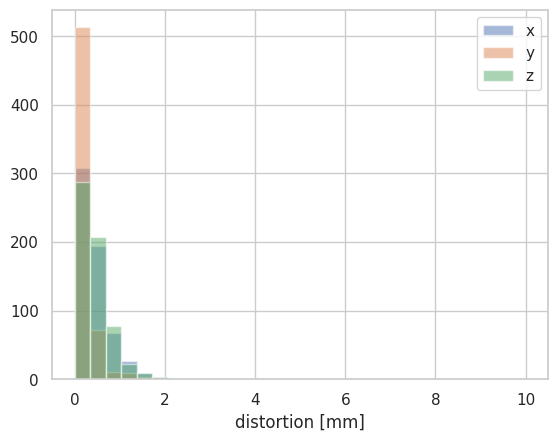

In [14]:
# Assess correction:
gt_data_loc = Path(r'/home/brendan/HairyHome/Downloads/FrankenGoam^Mr/CT/slicer_centroids.mrk.json')
gt_volume = MarkerVolume(gt_data_loc)
gt_volume.rotate_markers(yaxis_angle=90)  # have to reorient
gt_volume.rotate_markers(zaxis_angle=180)
gt_volume.rotate_markers(xaxis_angle=180)

corrected_volume = MarkerVolume(distorted_data_loc / 'corrected_dcm', n_markers_expected=609,  # nb 609 because end slice missing
                                iterative_segmentation=False,
                                gaussian_image_filter_sd=0.6,
                                threshold=412)
matched_volume_corrected = MatchedMarkerVolumes(gt_volume, corrected_volume, n_refernce_markers=9)
matched_volume_corrected.report()
plot_distortion_xyz_hist(matched_volume_corrected)